# Case Study Code on Kernel Support Vector Machine 

**python version: 2.7.13**

In [1]:
import time
import numpy as np
from itertools import cycle
from tensorflow.examples.tutorials.mnist import input_data

from sklearn import decomposition
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from matplotlib import colors as mcolors
import matplotlib.pyplot as plt
%matplotlib inline

## Get Data

Download [MNIST Dataset](http://yann.lecun.com/exdb/mnist/) from TensorFlow

In [2]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
train_x = mnist.train.images
train_y = mnist.train.labels
test_x = mnist.test.images
test_y = mnist.test.labels
valid_x = mnist.validation.images
valid_y = mnist.validation.labels

In [4]:
print "Training image matrix size: {}".format(train_x.shape)
print "Training label matrix size: {}".format(train_y.shape)
print "Testing image matrix size: {}".format(test_x.shape)
print "Testing label matrix size: {}".format(test_y.shape)
print "Validation image matrix size: {}".format(valid_x.shape)
print "Validation label matrix size: {}".format(valid_y.shape)

Training image matrix size: (55000, 784)
Training label matrix size: (55000, 10)
Testing image matrix size: (10000, 784)
Testing label matrix size: (10000, 10)
Validation image matrix size: (5000, 784)
Validation label matrix size: (5000, 10)


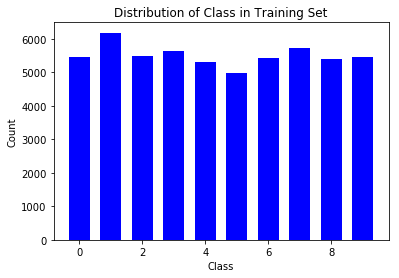

In [5]:
plt.bar(range(len(train_y.sum(0))), train_y.sum(0), 1/1.5, color="blue")
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Distribution of Class in Training Set")

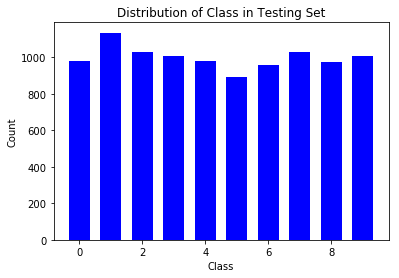

In [6]:
plt.bar(range(len(test_y.sum(0))), test_y.sum(0), 1/1.5, color="blue")
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Distribution of Class in Testing Set")

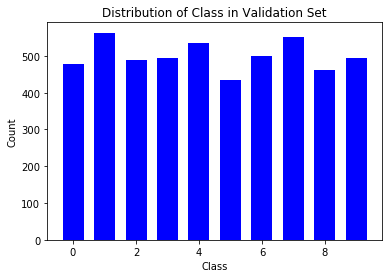

In [7]:
plt.bar(range(len(valid_y.sum(0))), valid_y.sum(0), 1/1.5, color="blue")
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Distribution of Class in Validation Set")

As shown above, there are 55,000 images in the training set, 10,000 images in the testing dataset, and 5,000 images in the validation dataset.

## Data Analysis

To understand what the data look like, here I plot the first 20 images from the training dataset.

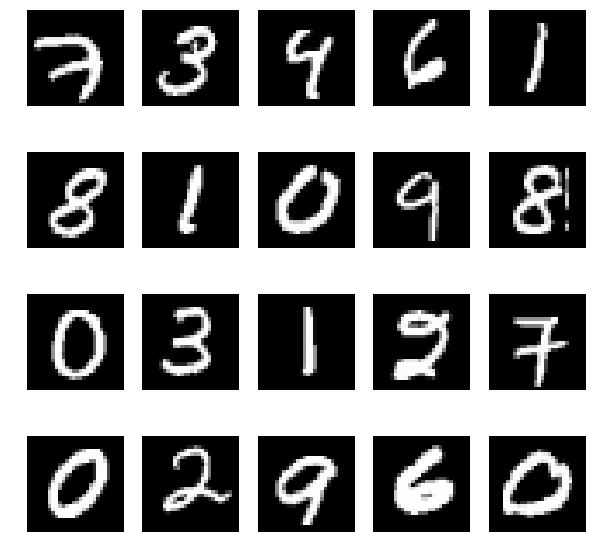

In [8]:
plt.figure(figsize=(10, 10))
for i in range(20):
    plt.subplot(4, 5, i+1)
    im = train_x[i].reshape(28,28)
    plt.imshow(im, interpolation="none", cmap="gray")
    plt.axis('off')

As shown above, each instance in the dataset is consisted of a size 28x28 greyscale handwritten digit image. Each image is unique from each other, and some of them have noise in the data.

In [9]:
print "Maxmimum data value: {}".format(train_x.max())
print "Minimum data value: {}".format(train_x.min())

Maxmimum data value: 1.0
Minimum data value: 0.0


The pixel intensity value ranges between 0 and 1, where 0 indicates the black pixel and 1 indicates the white pixel.

## Model Building

### Use Principal Component Analysis to Reduce the Dimensionality First

In [10]:
pca = decomposition.PCA()
pca.fit(train_x)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [11]:
var_exp = pca.explained_variance_ratio_*100
cum_var = np.cumsum(var_exp)

In [12]:
trace1 = go.Scatter(
    x=list(range(784)), y= cum_var,
    mode='lines+markers', name="'Cumulative Explained Variance'",
    hoverinfo= cum_var, line=dict(shape='spline', color = 'red'))

trace2 = go.Scatter(
    x=list(range(784)), y= var_exp,
    mode='lines+markers', name="'Individual Explained Variance'",
    hoverinfo= var_exp,line=dict(shape='linear', color = 'blue'))

fig = tls.make_subplots(print_grid=True)
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2,1,1)
fig.layout.title = 'Explained Variance plots'
fig.layout.xaxis = dict(range=[0, 784], title = 'Feature columns')
fig.layout.yaxis = dict(range=[0, 100], title = 'Explained Variance')
py.iplot(fig)

This is the format of your plot grid:
[ (1,1) x1,y1 ]



By inspecting the graph above, we only need to keep 154 principal components to preserve at least 95% of the original dataset variance.

In [13]:
pca = decomposition.PCA(n_components=154)
pca.fit(train_x)

PCA(copy=True, iterated_power='auto', n_components=154, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [14]:
pca_train_x = pca.transform(train_x)
pca_test_x = pca.transform(test_x)
pca_valid_x = pca.transform(valid_x)

In [15]:
# convert from binarize output to single array output
def convertOutput(arr):
    output_array = []
    for i in range(arr.shape[0]):
        for j in range(10):
            if arr[i][j] == 1:
                output_array.append(int(j))
    return np.array(output_array)

train_y_one = convertOutput(train_y)
test_y_one = convertOutput(test_y)
valid_y_one = convertOutput(valid_y)

print 'Training label: {}'.format(train_y_one[:10])
print 'Testing label: {}'.format(test_y_one[:10])
print 'Validation label: {}'.format(valid_y_one[:10])

Training label: [7 3 4 6 1 8 1 0 9 8]
Testing label: [7 2 1 0 4 1 4 9 5 9]
Validation label: [5 0 4 1 9 2 1 3 1 4]


Let's visualize the eigenvectors

In [16]:
eigenvectors = pca.components_

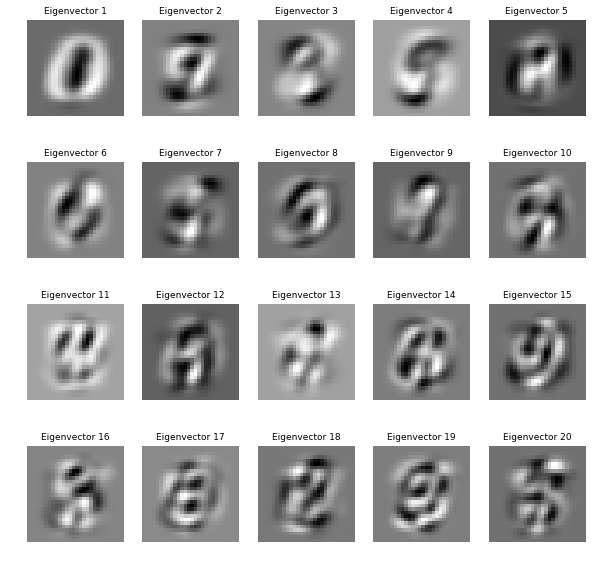

In [17]:
plt.figure(figsize=(10,10))
for i in list(range(20)):
    plt.subplot(4, 5, i + 1)
    plt.imshow(eigenvectors[i].reshape(28,28), interpolation="none", cmap='gray')
    plt.title('Eigenvector ' + str(i + 1), size=9)
    plt.axis('off')
plt.show()

See report for discussion

### Random Forest

5-fold cross validation to select the number of trees

In [245]:
n_trees = np.array(range(50, 70)) # test 20 parameters/models (50 to 69 trees)
start = time.time()
scores_rf = list()
scores_rf_std = list()
pca_rf = RandomForestClassifier()
for tree in n_trees: 
    pca_rf.n_estimators=tree
    this_score = cross_val_score(pca_rf, pca_train_x, train_y, cv=5, n_jobs=-1) # n_jobs=-1 meaning using all CPU
    scores_rf.append(np.mean(this_score))
    scores_rf_std.append(np.std(this_score))
    print "Finish training parameter {}".format(tree)
end = time.time()
print "Total running time: {} seconds".format(end-start)

Finish training parameter 50
Finish training parameter 51
Finish training parameter 52
Finish training parameter 53
Finish training parameter 54
Finish training parameter 55
Finish training parameter 56
Finish training parameter 57
Finish training parameter 58
Finish training parameter 59
Finish training parameter 60
Finish training parameter 61
Finish training parameter 62
Finish training parameter 63
Finish training parameter 64
Finish training parameter 65
Finish training parameter 66
Finish training parameter 67
Finish training parameter 68
Finish training parameter 69
Total running time: 1708.93776917 seconds


(50, 69)

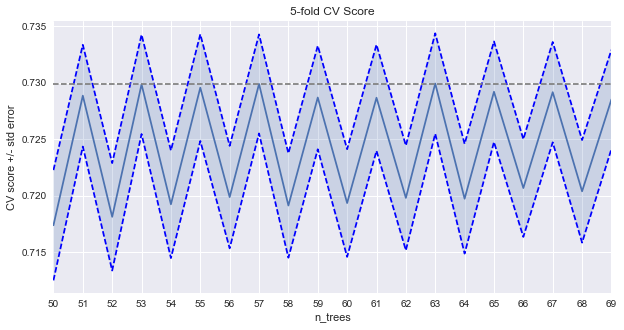

In [247]:
scores_rf, scores_rf_std = np.array(scores_rf), np.array(scores_rf_std)

plt.figure().set_size_inches(10, 5)
plt.plot(n_trees, scores_rf)

std_error = scores_rf_std / np.sqrt(5)

plt.plot(n_trees, scores_rf + std_error, 'b--')
plt.plot(n_trees, scores_rf - std_error, 'b--')

plt.fill_between(n_trees, scores_rf + std_error, scores_rf - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('n_trees')
plt.xticks(n_trees, n_trees)
plt.title('5-fold CV Score')
plt.axhline(np.max(scores_rf), linestyle='--', color='.5')
plt.xlim([n_trees[0], n_trees[-1]])

As shown above, we can build the RF model with 63 trees

In [18]:
pca_rf_tree = RandomForestClassifier(n_estimators=63)
pca_rf_tree.fit(pca_train_x, train_y_one)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=63, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

#### Test Set Result

In [19]:
pca_tree_test = pca_rf_tree.predict_proba(pca_test_x)
fpr_rf = dict()
tpr_rf = dict()
roc_auc_rf = dict()
for i in range(10):
    fpr_rf[i], tpr_rf[i], _ = roc_curve(test_y[:,i], pca_tree_test[:,i])
    roc_auc_rf[i] = auc(fpr_rf[i], tpr_rf[i])

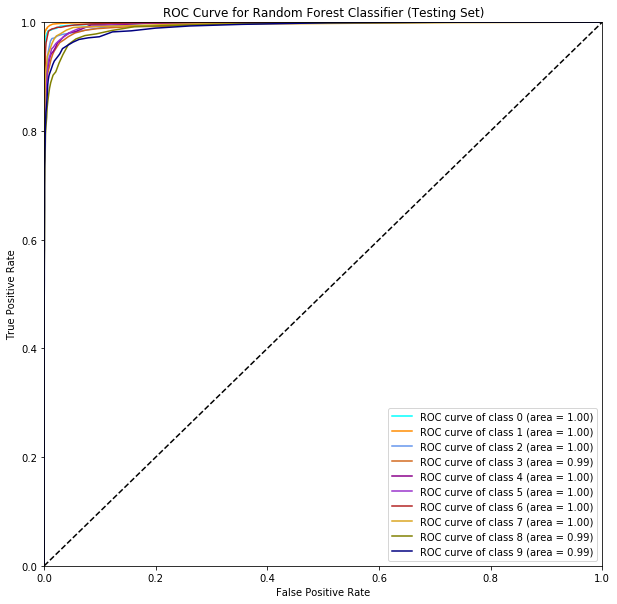

In [20]:
plt.figure().set_size_inches(10, 10)
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'chocolate', 'darkmagenta',
               'darkorchid', 'firebrick', 'goldenrod', 'olive', 'navy', 'sienna'])
for i, color in zip(range(10), colors):
    plt.plot(fpr_rf[i], tpr_rf[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc_rf[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest Classifier (Testing Set)')
plt.legend(loc="lower right")
plt.show()

##### Prediction Accuracy, Precision, Recall, and F1 score

In [21]:
accuracy_score(test_y_one, pca_rf_tree.predict(pca_test_x))

0.94230000000000003

In [22]:
rf_test_report = classification_report(test_y_one, pca_rf_tree.predict(pca_test_x))

In [23]:
print rf_test_report

             precision    recall  f1-score   support

          0       0.95      0.98      0.97       980
          1       0.98      0.98      0.98      1135
          2       0.94      0.94      0.94      1032
          3       0.91      0.94      0.93      1010
          4       0.93      0.95      0.94       982
          5       0.93      0.92      0.92       892
          6       0.96      0.97      0.96       958
          7       0.96      0.93      0.94      1028
          8       0.92      0.89      0.90       974
          9       0.94      0.92      0.93      1009

avg / total       0.94      0.94      0.94     10000



#### Validation Set Result

In [24]:
pca_tree_valid = pca_rf_tree.predict_proba(pca_valid_x)
fpr_rf_valid = dict()
tpr_rf_valid = dict()
roc_auc_rf_valid = dict()
for i in range(10):
    fpr_rf_valid[i], tpr_rf_valid[i], _ = roc_curve(valid_y[:,i], pca_tree_valid[:,i])
    roc_auc_rf_valid[i] = auc(fpr_rf_valid[i], tpr_rf_valid[i])

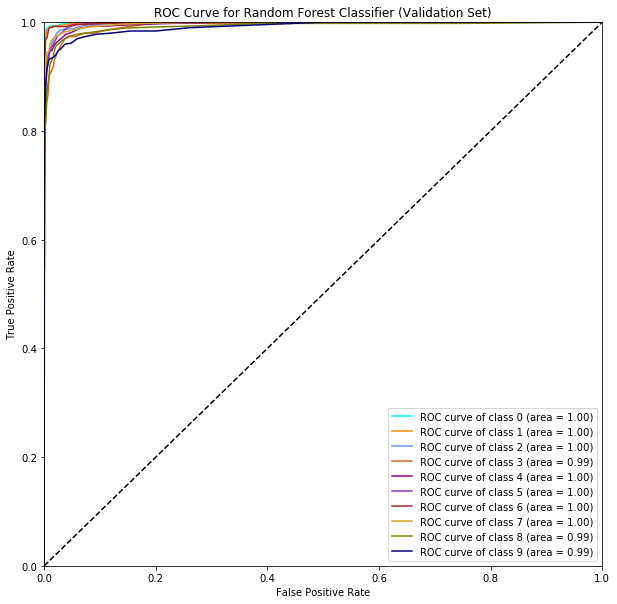

In [25]:
plt.figure().set_size_inches(10, 10)
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'chocolate', 'darkmagenta',
               'darkorchid', 'firebrick', 'goldenrod', 'olive', 'navy', 'sienna'])
for i, color in zip(range(10), colors):
    plt.plot(fpr_rf_valid[i], tpr_rf_valid[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc_rf_valid[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest Classifier (Validation Set)')
plt.legend(loc="lower right")
plt.show()

##### Prediction Accuracy, Precision, Recall and F1 score

In [26]:
accuracy_score(valid_y_one, pca_rf_tree.predict(pca_valid_x))

0.94599999999999995

In [27]:
rf_valid_report = classification_report(valid_y_one, pca_rf_tree.predict(pca_valid_x))

In [28]:
print rf_valid_report

             precision    recall  f1-score   support

          0       0.97      0.98      0.97       479
          1       0.97      0.98      0.98       563
          2       0.93      0.94      0.93       488
          3       0.91      0.92      0.92       493
          4       0.95      0.95      0.95       535
          5       0.92      0.92      0.92       434
          6       0.96      0.97      0.97       501
          7       0.95      0.95      0.95       550
          8       0.93      0.90      0.92       462
          9       0.96      0.92      0.94       495

avg / total       0.95      0.95      0.95      5000



### Support Vector Machine (Gaussian Radial Basis Function Kernel)

In [31]:
C_s = np.arange(0.1, 1.1, 0.1) # test 9 parameters/models (0.1 to 1)
start = time.time()
scores_gsvm = list()
scores_gsvm_std = list()
pca_gsvm = svm.SVC(decision_function_shape='ovr', probability=True)
for c in C_s: 
    pca_gsvm.C = c
    this_score = cross_val_score(pca_gsvm, pca_train_x, train_y_one, cv=5, n_jobs=-1) # n_jobs=-1 meaning using all CPU
    scores_gsvm.append(np.mean(this_score))
    scores_gsvm_std.append(np.std(this_score))
    print "Finish training parameter {}".format(c)
end = time.time()
print "Total running time: {} seconds".format(end-start)

Finish training parameter 0.1
Finish training parameter 0.2
Finish training parameter 0.3
Finish training parameter 0.4
Finish training parameter 0.5
Finish training parameter 0.6
Finish training parameter 0.7
Finish training parameter 0.8
Finish training parameter 0.9
Finish training parameter 1.0
Total running time: 6641.52188015 seconds


(0.10000000000000001, 1.0)

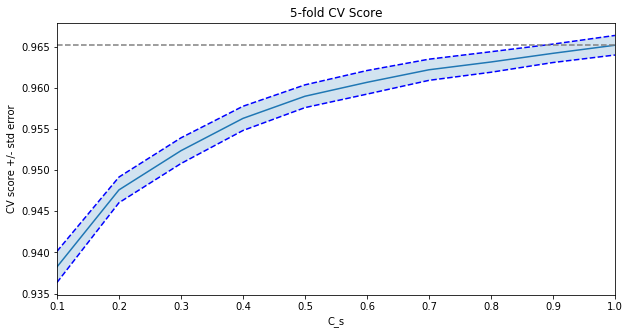

In [35]:
scores_gsvm, scores_gsvm_std = np.array(scores_gsvm), np.array(scores_gsvm_std)

plt.figure().set_size_inches(10, 5)
plt.plot(C_s, scores_gsvm)

std_error = scores_gsvm_std / np.sqrt(5)

plt.plot(C_s, scores_gsvm + std_error, 'b--')
plt.plot(C_s, scores_gsvm - std_error, 'b--')

plt.fill_between(C_s, scores_gsvm + std_error, scores_gsvm - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('C_s')
plt.xticks(C_s, C_s)
plt.title('5-fold CV Score')
plt.axhline(np.max(scores_gsvm), linestyle='--', color='.5')
plt.xlim([C_s[0], C_s[-1]])

In [306]:
start = time.time()
pca_svm1 = svm.SVC(decision_function_shape='ovr', probability=True)
pca_svm1.fit(pca_train_x, train_y_one)
end = time.time()
print "Total training time: {} seconds".format(end-start)

Total training time: 444.825191021 seconds


In [357]:
pca_svm1

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

##### Test set result

In [309]:
pca_svm_test = pca_svm1.predict_proba(pca_test_x)
fpr_svm = dict()
tpr_svm = dict()
roc_auc_svm = dict()
for i in range(10):
    fpr_svm[i], tpr_svm[i], _ = roc_curve(test_y[:,i], pca_svm_test[:,i])
    roc_auc_svm[i] = auc(fpr_svm[i], tpr_svm[i])

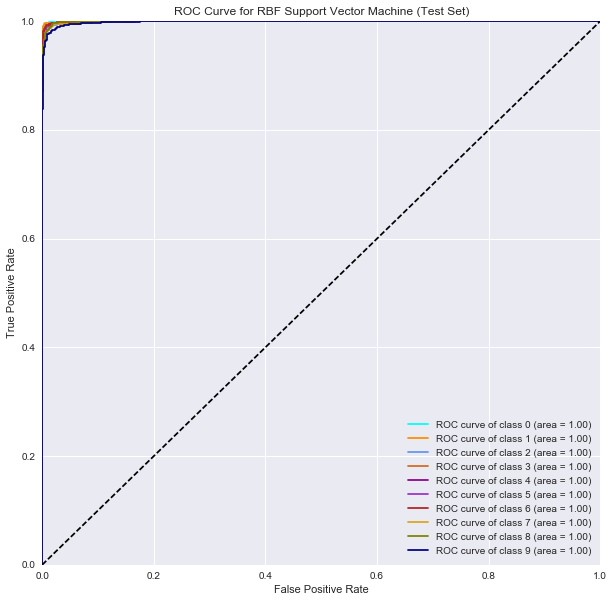

In [360]:
plt.figure().set_size_inches(10, 10)
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'chocolate', 'darkmagenta',
               'darkorchid', 'firebrick', 'goldenrod', 'olive', 'navy', 'sienna'])
for i, color in zip(range(10), colors):
    plt.plot(fpr_svm[i], tpr_svm[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc_svm[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for RBF Support Vector Machine (Test Set)')
plt.legend(loc="lower right")
plt.show()

##### Prediction Accuracy, Precision, Recall, and F1 score

In [314]:
accuracy_score(test_y_one, pca_svm1.predict(pca_test_x))

0.97050000000000003

In [315]:
svm_test_report = classification_report(test_y_one, pca_svm1.predict(pca_test_x))

In [316]:
print svm_test_report

             precision    recall  f1-score   support

          0       0.97      0.99      0.98       980
          1       0.98      0.99      0.99      1135
          2       0.97      0.97      0.97      1032
          3       0.96      0.97      0.97      1010
          4       0.97      0.97      0.97       982
          5       0.98      0.96      0.97       892
          6       0.98      0.98      0.98       958
          7       0.97      0.96      0.96      1028
          8       0.96      0.96      0.96       974
          9       0.97      0.95      0.96      1009

avg / total       0.97      0.97      0.97     10000



#### Validation Set Result

In [317]:
pca_svm_valid = pca_svm1.predict_proba(pca_valid_x)
fpr_svm_valid = dict()
tpr_svm_valid = dict()
roc_auc_svm_valid = dict()
for i in range(10):
    fpr_svm_valid[i], tpr_svm_valid[i], _ = roc_curve(valid_y[:,i], pca_svm_valid[:,i])
    roc_auc_svm_valid[i] = auc(fpr_svm_valid[i], tpr_svm_valid[i])

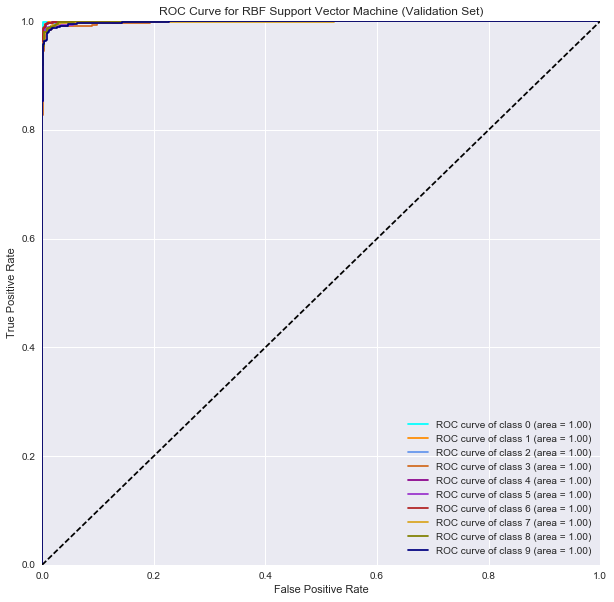

In [358]:
plt.figure().set_size_inches(10, 10)
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'chocolate', 'darkmagenta',
               'darkorchid', 'firebrick', 'goldenrod', 'olive', 'navy', 'sienna'])
for i, color in zip(range(10), colors):
    plt.plot(fpr_svm_valid[i], tpr_svm_valid[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc_svm_valid[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for RBF Support Vector Machine (Validation Set)')
plt.legend(loc="lower right")
plt.show()

##### Prediction Accuracy, Precision, Recall, and F1 score

In [325]:
accuracy_score(valid_y_one, pca_svm1.predict(pca_valid_x))

0.9738

In [326]:
svm_valid_report = classification_report(valid_y_one, pca_svm1.predict(pca_valid_x))

In [327]:
print svm_valid_report

             precision    recall  f1-score   support

          0       0.98      1.00      0.99       479
          1       0.97      0.99      0.98       563
          2       0.97      0.97      0.97       488
          3       0.96      0.96      0.96       493
          4       0.98      0.98      0.98       535
          5       0.97      0.97      0.97       434
          6       0.99      0.99      0.99       501
          7       0.98      0.97      0.97       550
          8       0.98      0.96      0.97       462
          9       0.98      0.95      0.97       495

avg / total       0.97      0.97      0.97      5000



### Support Vector Machine (Linear Kernel)

In [20]:
start = time.time()
pca_svm2 = svm.SVC(decision_function_shape='ovr', probability=True, kernel='linear')
pca_svm2.fit(pca_train_x, train_y_one)
end = time.time()
print "Total training time: {} seconds".format(end-start)

Total training time: 468.05719018 seconds


In [21]:
pca_svm2

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

#### Test Set Result

In [22]:
pca_lsvm_test = pca_svm2.predict_proba(pca_test_x)
fpr_lsvm = dict()
tpr_lsvm = dict()
roc_auc_lsvm = dict()
for i in range(10):
    fpr_lsvm[i], tpr_lsvm[i], _ = roc_curve(test_y[:,i], pca_lsvm_test[:,i])
    roc_auc_lsvm[i] = auc(fpr_lsvm[i], tpr_lsvm[i])

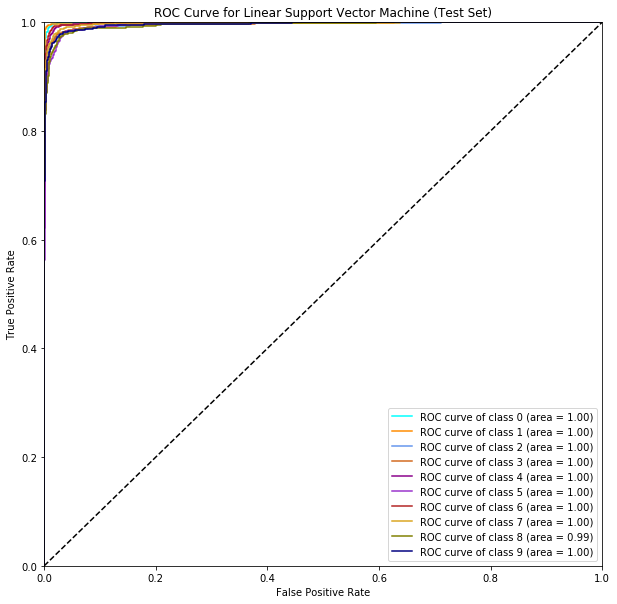

In [23]:
plt.figure().set_size_inches(10, 10)
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'chocolate', 'darkmagenta',
               'darkorchid', 'firebrick', 'goldenrod', 'olive', 'navy', 'sienna'])
for i, color in zip(range(10), colors):
    plt.plot(fpr_lsvm[i], tpr_lsvm[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc_lsvm[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Linear Support Vector Machine (Test Set)')
plt.legend(loc="lower right")
plt.show()

##### Prediction Accuracy, Precision, Recall, and F1 score

In [26]:
accuracy_score(test_y_one, pca_svm2.predict(pca_test_x))

0.94359999999999999

In [28]:
lsvm_test_report = classification_report(test_y_one, pca_svm2.predict(pca_test_x))

In [29]:
print lsvm_test_report

             precision    recall  f1-score   support

          0       0.96      0.98      0.97       980
          1       0.98      0.99      0.98      1135
          2       0.92      0.94      0.93      1032
          3       0.91      0.93      0.92      1010
          4       0.94      0.96      0.95       982
          5       0.92      0.90      0.91       892
          6       0.96      0.96      0.96       958
          7       0.95      0.94      0.95      1028
          8       0.93      0.91      0.92       974
          9       0.95      0.92      0.94      1009

avg / total       0.94      0.94      0.94     10000



#### Valid Set Result

In [30]:
pca_lsvm_valid = pca_svm2.predict_proba(pca_valid_x)
fpr_lsvm_valid = dict()
tpr_lsvm_valid = dict()
roc_auc_lsvm_valid = dict()
for i in range(10):
    fpr_lsvm_valid[i], tpr_lsvm_valid[i], _ = roc_curve(valid_y[:,i], pca_lsvm_valid[:,i])
    roc_auc_lsvm_valid[i] = auc(fpr_lsvm_valid[i], tpr_lsvm_valid[i])

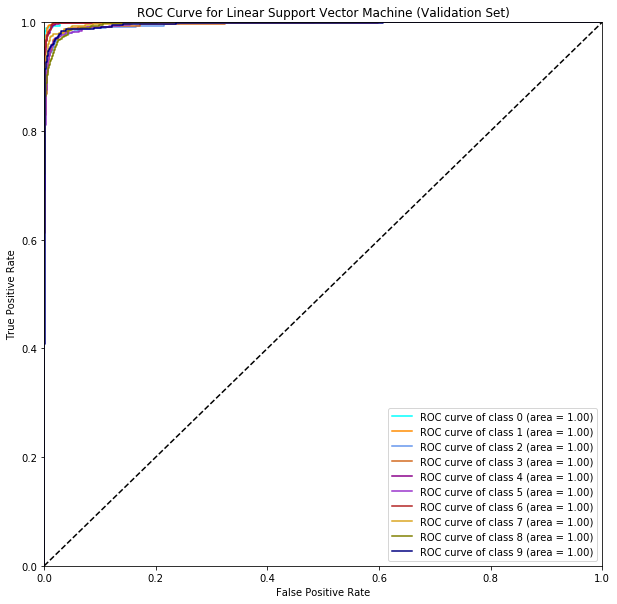

In [31]:
plt.figure().set_size_inches(10, 10)
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'chocolate', 'darkmagenta',
               'darkorchid', 'firebrick', 'goldenrod', 'olive', 'navy', 'sienna'])
for i, color in zip(range(10), colors):
    plt.plot(fpr_lsvm_valid[i], tpr_lsvm_valid[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc_lsvm_valid[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Linear Support Vector Machine (Validation Set)')
plt.legend(loc="lower right")
plt.show()

##### Prediction Accuracy, Precision, Recall, and F1 score

In [32]:
accuracy_score(valid_y_one, pca_svm2.predict(pca_valid_x))

0.94740000000000002

In [33]:
lsvm_valid_report = classification_report(valid_y_one, pca_svm2.predict(pca_valid_x))

In [34]:
print lsvm_valid_report

             precision    recall  f1-score   support

          0       0.96      0.98      0.97       479
          1       0.96      0.98      0.97       563
          2       0.93      0.93      0.93       488
          3       0.92      0.94      0.93       493
          4       0.96      0.97      0.96       535
          5       0.93      0.91      0.92       434
          6       0.96      0.97      0.97       501
          7       0.96      0.95      0.96       550
          8       0.93      0.91      0.92       462
          9       0.96      0.92      0.94       495

avg / total       0.95      0.95      0.95      5000



### Support Vector Machine (Sigmoid with Coefficient 0.5)

In [18]:
start = time.time()
pca_svm3 = svm.SVC(decision_function_shape='ovr', probability=True, kernel='sigmoid', coef0=0.5)
pca_svm3.fit(pca_train_x, train_y_one)
end = time.time()
print "Total training time: {} seconds".format(end-start)

Total training time: 594.481035948 seconds


In [19]:
pca_svm3

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.5,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='sigmoid',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

#### Test Set Result

In [21]:
pca_sigsvm_test = pca_svm3.predict_proba(pca_test_x)
fpr_sigsvm = dict()
tpr_sigsvm = dict()
roc_auc_sigsvm = dict()
for i in range(10):
    fpr_sigsvm[i], tpr_sigsvm[i], _ = roc_curve(test_y[:,i], pca_sigsvm_test[:,i])
    roc_auc_sigsvm[i] = auc(fpr_sigsvm[i], tpr_sigsvm[i])

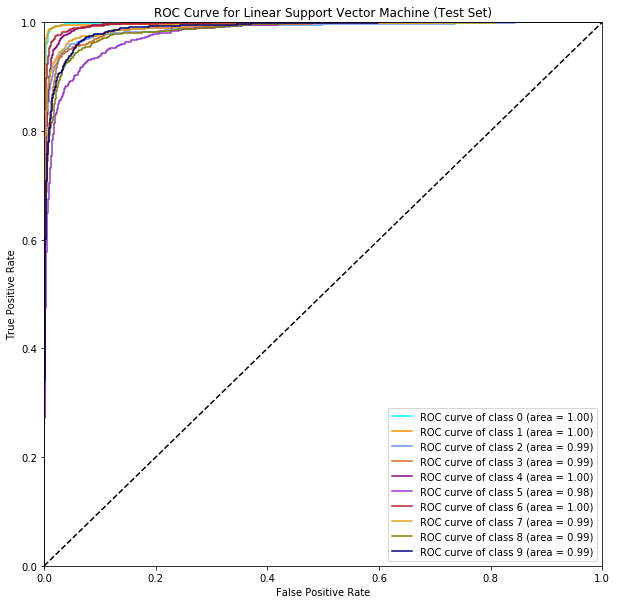

In [22]:
plt.figure().set_size_inches(10, 10)
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'chocolate', 'darkmagenta',
               'darkorchid', 'firebrick', 'goldenrod', 'olive', 'navy', 'sienna'])
for i, color in zip(range(10), colors):
    plt.plot(fpr_sigsvm[i], tpr_sigsvm[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc_sigsvm[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Sigmoid Support Vector Machine (Test Set)')
plt.legend(loc="lower right")
plt.show()

##### Prediction Accuracy, Precision, Recall, and F1 score

In [23]:
accuracy_score(test_y_one, pca_svm3.predict(pca_test_x))

0.89270000000000005

In [25]:
sigsvm_test_report = classification_report(test_y_one, pca_svm3.predict(pca_test_x))

In [28]:
print sigsvm_test_report

             precision    recall  f1-score   support

          0       0.92      0.98      0.95       980
          1       0.94      0.98      0.96      1135
          2       0.90      0.86      0.88      1032
          3       0.85      0.87      0.86      1010
          4       0.88      0.92      0.90       982
          5       0.81      0.81      0.81       892
          6       0.93      0.93      0.93       958
          7       0.91      0.90      0.91      1028
          8       0.88      0.82      0.85       974
          9       0.88      0.84      0.86      1009

avg / total       0.89      0.89      0.89     10000



#### Valid Set Result

In [30]:
pca_sigsvm_valid = pca_svm3.predict_proba(pca_valid_x)
fpr_sigsvm_valid = dict()
tpr_sigsvm_valid = dict()
roc_auc_sigsvm_valid = dict()
for i in range(10):
    fpr_sigsvm_valid[i], tpr_sigsvm_valid[i], _ = roc_curve(valid_y[:,i], pca_sigsvm_valid[:,i])
    roc_auc_sigsvm_valid[i] = auc(fpr_sigsvm_valid[i], tpr_sigsvm_valid[i])

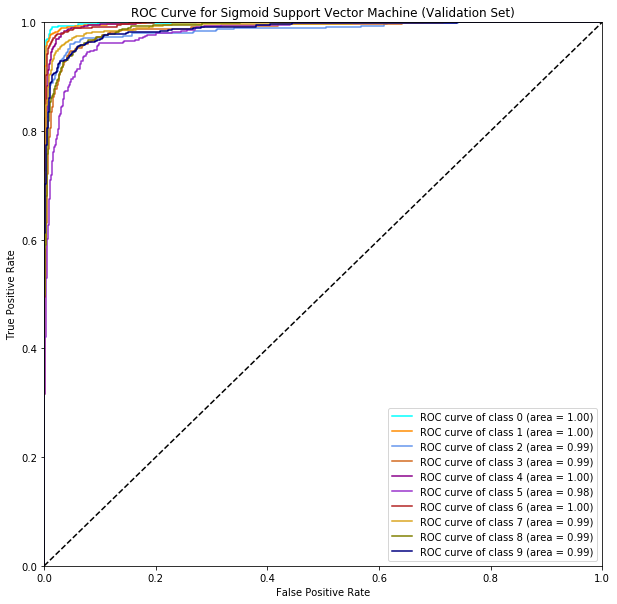

In [31]:
plt.figure().set_size_inches(10, 10)
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'chocolate', 'darkmagenta',
               'darkorchid', 'firebrick', 'goldenrod', 'olive', 'navy', 'sienna'])
for i, color in zip(range(10), colors):
    plt.plot(fpr_sigsvm_valid[i], tpr_sigsvm_valid[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc_sigsvm_valid[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Sigmoid Support Vector Machine (Validation Set)')
plt.legend(loc="lower right")
plt.show()

##### Prediction Accuracy, Precision, Recall, and F1 score

In [32]:
accuracy_score(valid_y_one, pca_svm3.predict(pca_valid_x))

0.89200000000000002

In [33]:
sigsvm_valid_report = classification_report(valid_y_one, pca_svm3.predict(pca_valid_x))

In [34]:
print sigsvm_valid_report

             precision    recall  f1-score   support

          0       0.93      0.97      0.95       479
          1       0.90      0.98      0.94       563
          2       0.87      0.88      0.87       488
          3       0.84      0.84      0.84       493
          4       0.90      0.94      0.92       535
          5       0.79      0.76      0.78       434
          6       0.95      0.94      0.94       501
          7       0.92      0.90      0.91       550
          8       0.89      0.82      0.85       462
          9       0.90      0.86      0.88       495

avg / total       0.89      0.89      0.89      5000

